***===== Imports =====***

*Pull in PyTorch and other required packages. Everything is kept deliberately minimal (just 'torch', 'nn', 'functional' and 'math' so that the mechanics of attention stay as transparent as possible*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

***===== dot product module =====***

*This cell implements teh fundamental attention operation used throughout the transformer.*

*Given queries **Q**, keys **K** and values **V**, attention computes,*

$$S=\frac{Q K^\top}{\sqrt{d_k}},
\qquad
A=\mathrm{softmax}(s),
\qquad
Y = A V.$$
                   
**S** is a matrix of all pairwise query-key similarity scores.
**A** is the Attention matrix (row-wise softmax so each row sums to 1).
**Y** is the final weighting sum of the value vectors.

**The function supports batched inputs of shape '(..., T, d_k/d_v)' and an optional boolean or float mask that zeros out future positions (causal mask) or padded tokens. Returniing the attention matrix makes debugging and visualisation easier**


In [2]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.shape[-1]
    scores = Q @ K.transpose(-2, -1) / (d_k ** 0.5)

    if mask is not None:
        if mask.dtype == torch.bool:
            scores = scores.masked_fill(~mask, -1e9)
        else:
            scores = scores + mask
    attn = F.softmax(scores, dim=-1)
    Y = attn @ V
    return Y, attn

***===== Causal mask helper =====***

A causal transformer should never be allowed position *t* to attend to future tokens *j > t*. To enforce this I build a lower-triangle boolean mask (torch.tril) of shape '(1, T, T)':

$$\text{mask}_{t,j} = 
\begin{cases}
1 & j \le t \\
0 & j > t.
    \end{cases}$$

The mask is broadcast across the batch dimension. When passed into attention, masked positions receive a large negative score (~-1e9) before the sofmax, meaning their probability effectively becomes zero.

In [3]:
def make_causal_mask(x):
    B, T, _ = x.shape
    mask = torch.tril(torch.ones(T, T, dtype=torch.bool, device=x.device))
    return mask.unsqueeze(0)

***===== SelfAttention module (single head) =====***

This nodule bundles three linear projections:

$( Q = X W_Q)$
$( K = X W_K)$
$( V = X W_V)$

and then calls the scaled_dot_product_attention module from the previous cell.

Input shape is '(B, T, d_model)' and the output has shape '(B, T, d_v)'. By default I set 'd_l = d_v = d_model', which makes it compatible with residual connections in full transformer blocks.

If 'causal=true', the layer uses the causal mask so each position only atteends to the past. This is wexactly the "self-attention" primitive used by GPT-style transformers.

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, d_k=None, d_v=None, causal=True, return_attn=False, use_linear=True):
        """
        use_linear=True: use nn.Linear for Q/K/V projections
        use_linear =False: use nn.Parameter weight matrices and manual matmul
        
        nn.Linear is a learnable matrix transformation that converts token 
        embeddings into Queries, Keys and Values - the three different 
        vector spaces the attention mechanism uses.
        
        nn.Parameter is a learned weight matrix; this exposes the underlying
        matrix multiply explicitly, but is mathematically identical to using
        nn.Linear without bias
        """

        super().__init__()
        d_k = d_k or d_model
        d_v = d_v or d_model

        self.causal = causal
        self.return_attn = return_attn
        self.use_linear=use_linear

        # =============================
        # Option 1 nn.Linear (clean, high level, recommendede)
        # =============================
        if self.use_linear:
            # each linear layer holds a weight matrix AND handles the
            # batch/sequence dimensions for us.
            # No bias is needed for Q/K/V projections
            self.W_Q = nn.Linear(d_model, d_k, bias=False)
            self.W_K = nn.Linear(d_model, d_k, bias=False)
            self.W_V = nn.Linear(d_model, d_k, bias=False)
        else:
            # ==========================
            # ption 2: nn.Parameter + manual matrix multiplication
            # ==========================
            # we explicitly store weight matrices
            # W_Q \in \mathbb{R}^(d_model x d_k}
            # W_K \in \mathbb{R}^(d_model x d_k}
            # W_V \in \mathbb{R}^(d_model x d_k}
            #
            # This is what linear does internally, except here we expose
            # the raw matrices to do that matmul ourselves.
            #
            # The shapes use [d_model, d_k] so that;
            # (B, T, d_model) @ (d_model, d_k) -> (B, T, d_k)
            self.W_Q = nn.Parameter(torch.randn(d_model, d_k) * (1 / d_model))
            self.W_K = nn.Parameter(torch.randn(d_model, d_k) * (1 / d_model))
            self.W_V = nn.Parameter(torch.randn(d_model, d_k) * (1 / d_model))
            
    def forward(self, x, mask=None):
        B, T, _ = x.shape
        if self.use_linear:
            # High level linear layers automatically apply:
            # Q = x W_Q^T, K = x W_K^T, V = x W_V^T
            Q = self.W_Q(x)
            K = self.W_K(x)
            V = self.W_V(x)
        else:
            # Manual weight matrices using nn.Parameter
            # perform explicit matrix multiplies:
            #
            # Q[b, t] = x[b,t]@W_Q -> shape (d_k)
            #
            # same for K, V
            #
            Q = x @ self.W_Q # (B, T, d_k)
            K = x @ self.W_K # (B, T, d_k)
            V = x @ self.W_V # (B, T, d_k)

        if mask is None and self.causal:
            mask = make_causal_mask(x)

        Y, attn = scaled_dot_product_attention(Q, K, V, mask=mask)

        if self.return_attn:
            return Y, attn
        return Y        

***===== Sanity check =====***

To confirm that the 'SelfAttention' module is correct, I directly compare:

1. The output of the 'SelfAttention' module on an input 'x'.
2. The output of manually computing $( Q = X W_Q)$, $( K = X W_K)$, $( V = X W_V)$, building the causal mask, and calling the 'scaled_dot_product_attention' module explicitlly.

Both paths should agree up to a level of tolerance:

$$y_{\text{module}} \approx y_{\text{manual}}, \qquad
A_{\text{module}} \approx A_{\text{manual}}.$$

Running this test once gives me the confidence that the implementation bahaves exactly as intended and matches the mathematical definition.

In [9]:
def test_self_attention(use_linear: bool):
    torch.manual_seed(0)

    B, T, d_model = 2, 3, 4
    x = torch.randn(B, T, d_model)

    sa = SelfAttention(d_model, causal=True, return_attn=True, use_linear=False)
    # run via module
    y1, attn1 = sa(x)

    # Run manually reconstruct Q, K, V using SAME weights ---
    if isinstance(sa.W_Q, nn.Linear):
        # nn.Linear version:
        # 'a learnable matrix transformation that converts token embeddings into
        # queries, keys and values - three different vector spaces the 
        # attention mechanism uses
        Q = sa.W_Q(x)
        K = sa.W_K(x)
        V = sa.W_V(x)
    else:
        # nn>parameter version:
        # a manually learned weight matrix, this exposes the underlying
        # matrix multiply explicitly, but is mathematically identical to
        # using nn.Linear without bias
        Q = x @ sa.W_Q
        K = x @ sa.W_K
        V = x @ sa.W_V
    mask = make_causal_mask(x)

    y2, attn2 = scaled_dot_product_attention(Q, K, V, mask=mask)

    assert torch.allclose(y1, y2, atol=1e-6)
    assert torch.allclose(attn1, attn2, atol=1e-6)

    mode = "nn.Linear" if isinstance(sa.W_Q, nn.Linear) else "nn.Parameter"
    print(f"SelfAttention ({mode}) matches 'scaled_dot_product_attention()' Yay")

test_self_attention(use_linear=True)

SelfAttention (nn.Parameter) matches 'scaled_dot_product_attention()' Yay


Understanding self-attention is much easier when i can see how each token attends to every other token. Visualising the attention matrix

$$ A \in \mathbb{R}^{T \timesT}

produced by the attention layer helps this. Recalling that self attention produces weights by computing:

$$S = \frac{QK^\top}{\sqrt{d_k}}.$$

and optionally adding a mask (causal or padding) t

$$S' = S + \text{mask}$$

The attention weights are obtained by applying a row-wise softmax:

$$A = \operatorname{softmax}(S')

Finally the output of attention is the weighted sum of values:

$$Y = A V$$

***What the Heatmap shows***
* Each *row* of A corressponds to a *query position t*.
* Each *column* corresponds to a *key/value position j*.
* The intensity of a cell is the attention weight $\alpha_{t j}$.

    




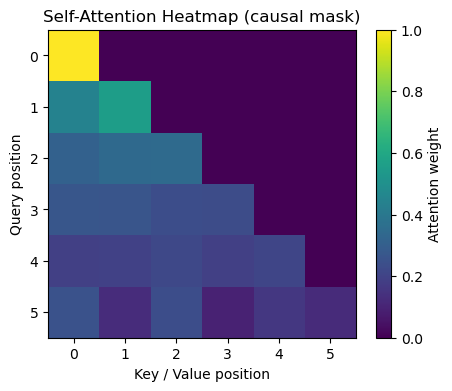

In [10]:
torch.manual_seed(0)
x=torch.randn(1,6,8)

sa=SelfAttention(d_model=8, causal=True, return_attn=True)
y, attn = sa(x)

# remove batch dimension for plotting
A = attn[0].detach().cpu().numpy()

plt.figure(figsize=(5,4))
plt.imshow(A, cmap='viridis')
plt.title("Self-Attention Heatmap (causal mask)")
plt.xlabel("Key / Value position")
plt.ylabel("Query position")
plt.colorbar(label="Attention weight")
plt.show()

In [16]:
def test_self_attention_reduces_to_average():
    """
    Verify that with W__Q =0, W_K = 0 and W_CV = I (and no causal mask),
    self attention reduces to a simple average over positions.

    For each batch item b abd time t:
        y[b,t,:] should equal the mean over all positions j of x[b, j, :].
    """
    torch.manual_seed(0)

    B, T, d_model = 2,4,3
    x = torch.randn(B, T, d_model)

    # use the nn.Parameter path so we can explicitly set W_Q, W_K and W_V
    sa = SelfAttention(
        d_mdel=d_model,
        d_k=d_model,
        d_v=d_model,
        causal=False,
        returns_attn=False,
        use_linear=False)

    # W_Q = 0, W_K = 0, W_V = I
    with torch.no_grad():
        sa.W_Q.zero_()
        sa.W_K.zero_()
        sa.W_V.copy.copy_(torch.eye(d_model))

    # run through the layer
    y, attn = sa(x)

    # Expected: simple average over positions, same at every t
    # shape (B, 1, d_model), then broadcast to (B, T, d_model)
    mean_over_T = x.mean(dim=1, keepdim=True)
    expected_y = mean_over_T.expand_as(y)

    assert torch.allclose(y, expected_y, atol=1e-6)
    print("SelfAttention reduces to simple average over positions")   

In [17]:
def naive_scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Naive reference implementation of scaled dot-product attention
    using explicit Python loops. Only for small tensors in tests.

    Q, K, V: (B, T, d_k/d_v)
    mask:    broadcastable to (B, T, T) or None

    returns:
        Y:    (B, T, d_v)
        attn: (B, T, T)
    """
    B, T, d_k = Q.shape
    d_v = V.shape[-1]
    device = Q.device

    # Ensure we have a float mask with -inf for masked positions, or None
    if mask is not None:
        # Broadcast mask to (B, T, T)
        mask = mask.to(device)
        if mask.dtype == torch.bool:
            # True = keep, False = mask → convert to 0 or -1e9
            mask_full = torch.zeros(B, T, T, device=device)
            mask_full = mask_full.masked_fill(~mask, -1e9)
        else:
            mask_full = mask.expand(B, T, T)
    else:
        mask_full = None

    Y = torch.zeros(B, T, d_v, device=device)
    attn = torch.zeros(B, T, T, device=device)

    for b in range(B):
        for t in range(T):
            # 1. Compute scores for all j
            scores = torch.empty(T, device=device)
            for j in range(T):
                scores[j] = (Q[b, t] @ K[b, j]) / (d_k ** 0.5)
                if mask_full is not None:
                    scores[j] += mask_full[b, t, j]

            # 2. Softmax over j
            max_score = scores.max()
            exp_scores = torch.exp(scores - max_score)
            probs = exp_scores / exp_scores.sum()

            attn[b, t] = probs

            # 3. Weighted sum over V
            y_t = torch.zeros(d_v, device=device)
            for j in range(T):
                y_t += probs[j] * V[b, j]
            Y[b, t] = y_t

    return Y, attn


In [18]:
def test_scaled_dot_product_attention_matches_naive():
    """
    Compare the vectorised scaled_dot_product_attention against
    the naive double-loop reference implementation on a tiny example.
    """
    torch.manual_seed(0)

    B, T, d_k, d_v = 2, 3, 4, 5
    Q = torch.randn(B, T, d_k)
    K = torch.randn(B, T, d_k)
    V = torch.randn(B, T, d_v)

    # Example mask: causal
    x_dummy = torch.zeros(B, T, d_k)
    mask = make_causal_mask(x_dummy)  # (1, T, T)

    Y_fast, A_fast = scaled_dot_product_attention(Q, K, V, mask=mask)
    Y_slow, A_slow = naive_scaled_dot_product_attention(Q, K, V, mask=mask)

    assert torch.allclose(Y_fast, Y_slow, atol=1e-6)
    assert torch.allclose(A_fast, A_slow, atol=1e-6)
    print("Vectorised attention matches naive double-loop implementation ✅")
